# Training

This notebook visualizes some aspects of the training process.

## Learning rate scheduler

The learning rate scheduler adapts the learning rate according to the amount of epochs.

The scheduler also has a stateful variant that can be updated at every step and epoch.

/gpfs/home3/kstolle/projects/unicore/sources/unicore/file_io.py:92: UserWarning: Environment variable UNICORE_SCRATCH not defined, using default './scratch'.
  EnvPathHandler("//scratch/", "UNICORE_SCRATCH", "./scratch")


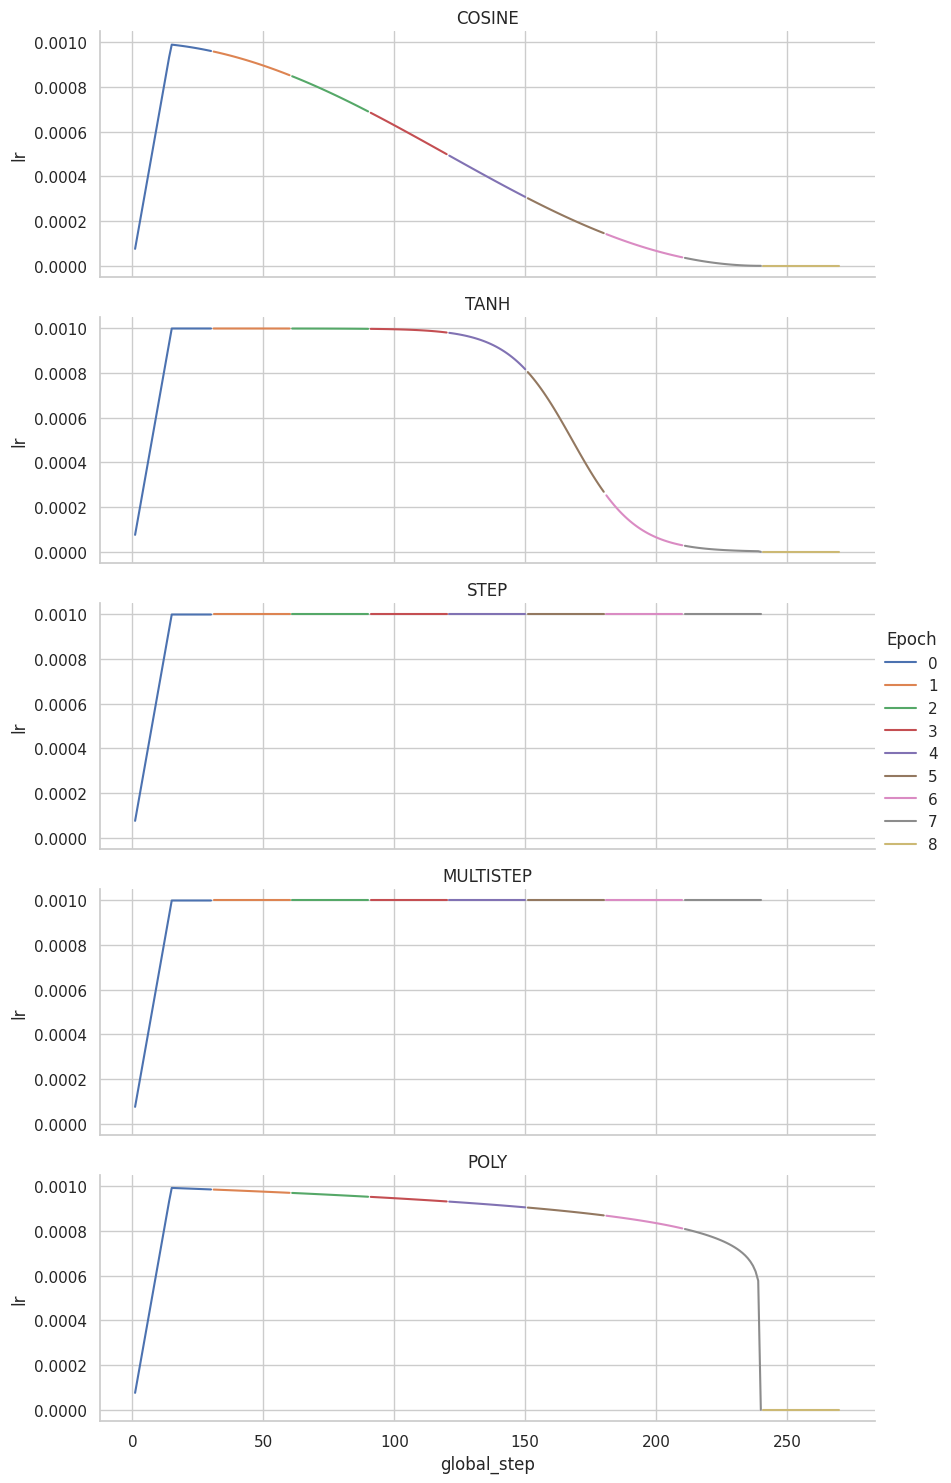

In [1]:
import unipercept as up
import torch.nn as nn
import torch.optim
from timm.scheduler.scheduler import Scheduler as TimmScheduler
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(context="notebook", style="whitegrid")

scheduled_epochs = 8
updates_per_epoch = 30

def _read_lr(optimizer) -> float:
    return float(optimizer.param_groups[0]['lr'])


df_rows = []

for scd in up.trainer.SchedType:
    model = nn.Linear(20, 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler_factory = up.trainer.SchedulerFactory(scd, warmup_epochs=0.5, cooldown_epochs=1)
    try:
        scheduler, epoch_amount = scheduler_factory(optimizer, scheduled_epochs, updates_per_epoch=updates_per_epoch)
        global_steps = 0
        for epoch in range(epoch_amount):
            for step in range(updates_per_epoch):
                global_steps += 1
                scheduler.step_update(global_steps, None)
                df_rows.append({'name': scd.name, 'global_step': global_steps, 'epoch': epoch, 'step': step, 'lr': _read_lr(optimizer)})
            scheduler.step(epoch, None)

    except Exception as err:
        pass

df = pd.DataFrame(df_rows)

g = sns.FacetGrid(df, hue="epoch", col="name", col_wrap=1, height=3, aspect=3, sharex=True, sharey=True, margin_titles=True, legend_out=True)
g.set_titles(col_template="{col_name}")
g.map(sns.lineplot, "global_step", "lr")
g.add_legend(title="Epoch")

plt.show()


## Inference in the Trainer class

Loading a model trained using the Trainer can be achieved by first initializing the checkpoint in the Trainer, and 
then exporting that model to a regular PyTorch checkpoint or using the Trainer's evaluation methods directly.

In [3]:
import unipercept as up
import torch
from unicore import file_io

DATASET_NAME = "cityscapes/vps"
DATASET_INFO = up.data.sets.get_info(DATASET_NAME)
SESSION_PATH = file_io.Path("//output/cityscapes/multidvps_resnet50/2023-11-07_10-31-46@gcn23.local.snellius.surf.nl")

cfg_path = SESSION_PATH / "config.yaml"
cfg = up.utils.config.LazyConfig.load(str(cfg_path))

model = up.utils.config.instantiate(cfg.model)
trainer = up.utils.config.instantiate(cfg.trainer)
trainer.recover(model)

print(model)



[11/07 11:22:02 unipercept.trainer]: Initializing Trainer: cityscapes/multidvps_resnet50 @ 2023-11-07_10-31-46@gcn23.local.snellius.surf.nl
[11/07 11:22:02 unipercept.trainer]: Using directory: /gpfs/work4/0/einf5438/outputs/cityscapes/multidvps_resnet50/2023-11-07_10-31-46@gcn23.local.snellius.surf.nl


[11/07 11:22:02 unipercept.trainer]: Using accelerator: 
{'automatic_checkpoint_naming': True,
 'iteration': 0,
 'logging_dir': '/gpfs/work4/0/einf5438/outputs/cityscapes/multidvps_resnet50/2023-11-07_10-31-46@gcn23.local.snellius.surf.nl/logs',
 'project_dir': '/gpfs/work4/0/einf5438/outputs/cityscapes/multidvps_resnet50/2023-11-07_10-31-46@gcn23.local.snellius.surf.nl/outputs',
 'save_on_each_node': False,
 'total_limit': None}
[11/07 11:22:02 unipercept.trainer]: Current process: 0 / 1
MultiDVPS(
  (backbone): FeaturePyramidBackbone(
    (base): TimmBackbone(
      (normalize): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
      (ext): FeatureGraphNet(
        (graph_module): ResNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_si

## Evaluation in the `Trainer` class

### Results directory

Evaluation intermediates are temporarily stored in the project directory. The following sections inspect such an evaluation directory.

<class 'tensordict.memmap.MemmapTensor'>
<class 'tensordict.memmap.MemmapTensor'>
<class 'tensordict.memmap.MemmapTensor'>
<class 'tensordict.memmap.MemmapTensor'>
<class 'tensordict.memmap.MemmapTensor'>
TensorDict(
    fields={
        pred_depth: MemmapTensor(shape=torch.Size([304, 1024, 2048]), device=cpu, dtype=torch.float32, is_shared=False),
        pred_panoptic: MemmapTensor(shape=torch.Size([304, 1024, 2048]), device=cpu, dtype=torch.int64, is_shared=False),
        true_depth: MemmapTensor(shape=torch.Size([304, 1024, 2048]), device=cpu, dtype=torch.float32, is_shared=False),
        true_panoptic: MemmapTensor(shape=torch.Size([304, 1024, 2048]), device=cpu, dtype=torch.int64, is_shared=False),
        valid: MemmapTensor(shape=torch.Size([304]), device=cpu, dtype=torch.bool, is_shared=False)},
    batch_size=torch.Size([304]),
    device=None,
    is_shared=False)


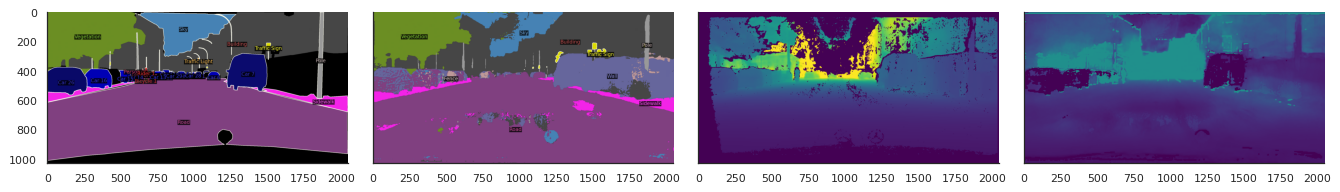

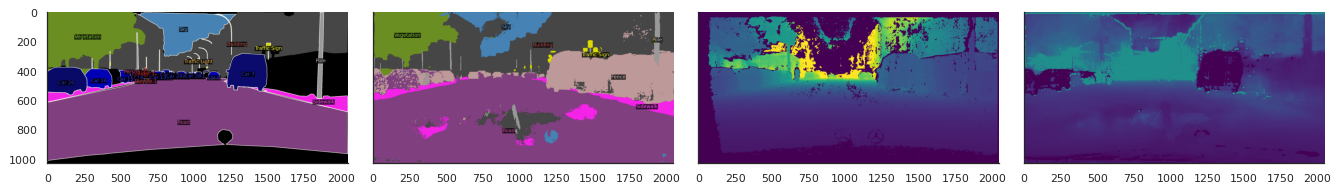

In [2]:
import unipercept as up
import torch
from tensordict import TensorDict
from unicore import file_io
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="paper", style="white")

DATASET_NAME = "cityscapes/vps"
DATASET_INFO = up.data.sets.get_info(DATASET_NAME)
RESULTS_DIR = file_io.Path("//output/cityscapes/multidvps_resnet50/2023-11-09_05-38-27@gcn31.local.snellius.surf.nl")

assert RESULTS_DIR.is_dir(), f"Not a directory: {str(RESULTS_DIR)}"

td = TensorDict.load_memmap(RESULTS_DIR / "outputs" / "evaluation" / "results-17500")
print(td)

example_amount = 2
for i, result in enumerate(td):
    if i >= example_amount:
        break

    fig, ax = plt.subplots(1, 4, squeeze=False, figsize=(15,5), dpi=90, sharex=True, sharey=True)
        
    for n, panseg in enumerate([result["true_panoptic"], result["pred_panoptic"]]):
        panseg = panseg.clone().as_subclass(up.data.tensors.PanopticMap)
        
        img = up.render.utils.draw_image_segmentation(panseg, info=DATASET_INFO)

        ax[0,n].imshow(img)

    for n, tensor in enumerate([result["true_depth"], result["pred_depth"]]):
        tensor = tensor.clone().as_subclass(up.data.tensors.DepthMap)
        img = up.render.utils.draw_image_depth(tensor, info=DATASET_INFO)

        ax[0,2 + n].imshow(img)

    sns.despine()
    fig.tight_layout()

### Defining metrics

We compute metrics using the classes provided in `unipercept.evaluators`.

In [3]:
from pprint import pformat

evaluators = [up.evaluators.PanopticEvaluator.from_metadata(DATASET_NAME, show_progress=True)]

print("Computing evaluation metrics...")

for evaluator in evaluators:
    metrics = evaluator.compute(td, device=torch.device("cuda"))
    print(pformat(metrics))

[11/06 10:29:47 unipercept.evaluators]: Initialized panoptic evaluator with 8 things ({11: 'person', 12: 'rider', 13: 'car', 14: 'truck', 15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle'}) and 11 stuff ({0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain', 10: 'sky'}).
Computing evaluation metrics...
PanopticEvaluator(render=False, things={11: 'person', 12: 'rider', 13: 'car', 14: 'truck', 15: 'bus', 16: 'train', 17: 'motorcycle', 18: 'bicycle'}, stuff={0: 'road', 1: 'sidewalk', 2: 'building', 3: 'wall', 4: 'fence', 5: 'pole', 6: 'traffic light', 7: 'traffic sign', 8: 'vegetation', 9: 'terrain', 10: 'sky'}, show_progress=True)
[11/06 10:29:47 unipercept.evaluators]: Starting evaluation of 304 samples in 16 workers


accumulating pqs: 100%|██████████| 304/304 [02:37<00:00,  1.93it/s]

[11/06 10:32:25 unipercept.evaluators]: Starting evaluation of 304 samples in 16 workers



accumulating pqs: 100%|██████████| 304/304 [00:04<00:00, 63.54it/s]

{'pq_mod': {'fn': 150.52631578947367,
            'fp': 7.789473684210526,
            'iou': 8.099970384647971,
            'pq': 0.026644639423184114,
            'tp': 73.05263157894737},
 'pq_ori': {'fn': 215.57894736842104,
            'fp': 8.0,
            'iou': 8.0,
            'pq': 0.03478260869565217,
            'tp': 8.0}}
